<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il

In [2]:
def read_data(url, dataset_name, sep=","):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep)
    
df = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)

df.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
12923,976,2020-07-20,3,0,0,3
12924,976,2020-07-21,0,0,0,0
12925,976,2020-07-22,6,2,0,2
12926,976,2020-07-23,2,0,0,3
12927,976,2020-07-24,5,0,0,2


In [3]:
def display_df(df, title, logscale=False):
    """
    df a pour index les jours et les cols ["incid_hosp", "incid_rea"]
    """
    daily = df[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if daily["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_desaiso"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]
        disp = ["incid_hosp", "incid_rea", "hosp_lisse"]

    plt.figure(figsize=(15,8))
    if logscale:
        plt.yscale('log')
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(title, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données : \n")
    print(dept[disp].apply(np.rint).tail(8))

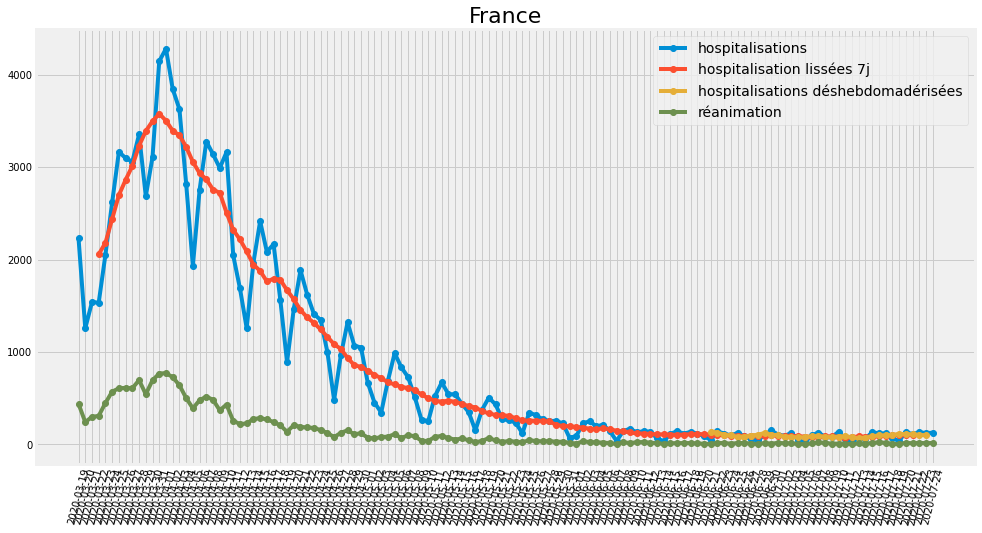


dernières données : 

            incid_hosp  incid_rea  hosp_desaiso
2020-07-17       119.0       17.0          98.0
2020-07-18        68.0        6.0         102.0
2020-07-19        36.0        4.0         114.0
2020-07-20       137.0       18.0         112.0
2020-07-21       109.0       12.0         109.0
2020-07-22       132.0       17.0         103.0
2020-07-23       123.0       13.0         100.0
2020-07-24       126.0       16.0           NaN


In [4]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France")


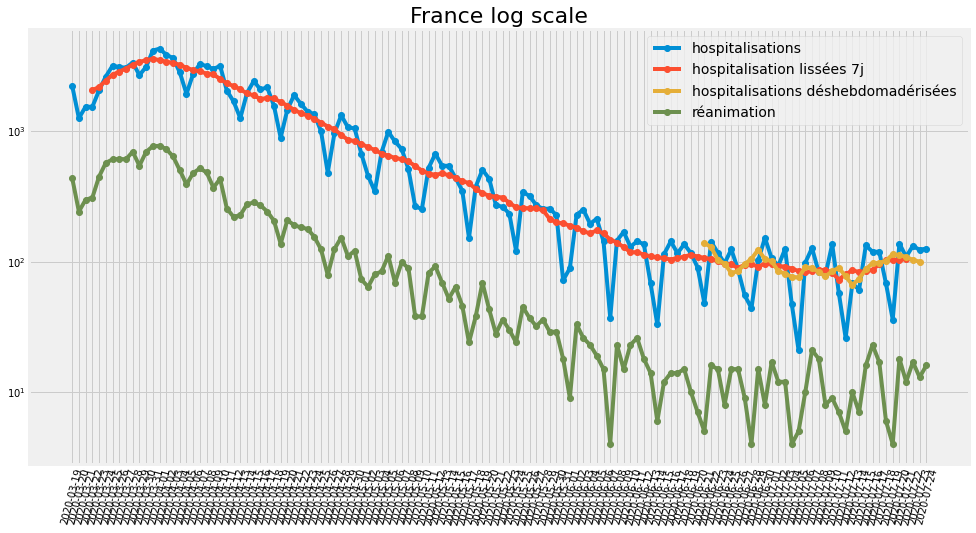


dernières données : 

            incid_hosp  incid_rea  hosp_desaiso
2020-07-17       119.0       17.0          98.0
2020-07-18        68.0        6.0         102.0
2020-07-19        36.0        4.0         114.0
2020-07-20       137.0       18.0         112.0
2020-07-21       109.0       12.0         109.0
2020-07-22       132.0       17.0         103.0
2020-07-23       123.0       13.0         100.0
2020-07-24       126.0       16.0           NaN


In [5]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France log scale", logscale=True)

In [6]:
def display_dept(d_number, d_name):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)

    daily = dept[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if dept["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "réanimation"]

    plt.figure(figsize=(15,8))
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données lissées 7j: \n")
    print(dept.rolling(7).mean().apply(np.rint).tail())
    

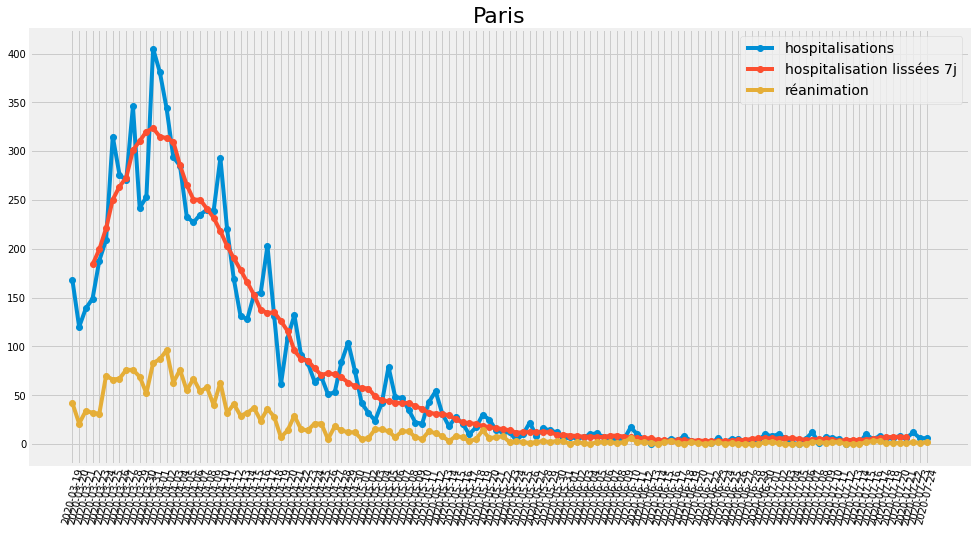


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         8.0        3.0         6.0
2020-07-18         6.0        1.0         7.0
2020-07-19         6.0        1.0         7.0
2020-07-20         8.0        1.0         7.0
2020-07-21         6.0        1.0         7.0
2020-07-22        12.0        2.0         NaN
2020-07-23         6.0        1.0         NaN
2020-07-24         6.0        2.0         NaN


In [7]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris")

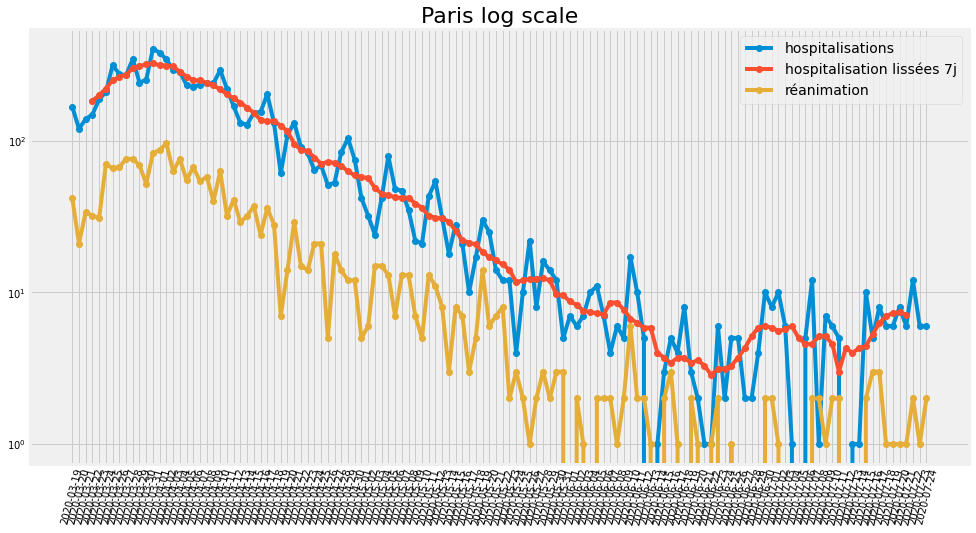


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         8.0        3.0         6.0
2020-07-18         6.0        1.0         7.0
2020-07-19         6.0        1.0         7.0
2020-07-20         8.0        1.0         7.0
2020-07-21         6.0        1.0         7.0
2020-07-22        12.0        2.0         NaN
2020-07-23         6.0        1.0         NaN
2020-07-24         6.0        2.0         NaN


In [8]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris log scale", True)

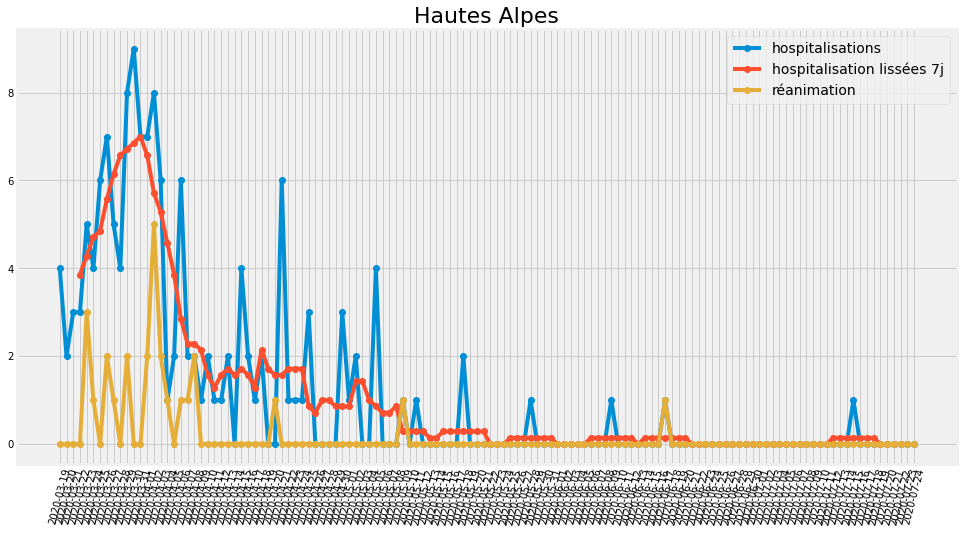


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         0.0        0.0         0.0
2020-07-18         0.0        0.0         0.0
2020-07-19         0.0        0.0         0.0
2020-07-20         0.0        0.0         0.0
2020-07-21         0.0        0.0         0.0
2020-07-22         0.0        0.0         NaN
2020-07-23         0.0        0.0         NaN
2020-07-24         0.0        0.0         NaN


In [9]:
display_df(df[df.dep=="05"].set_index("jour", drop=True),"Hautes Alpes")

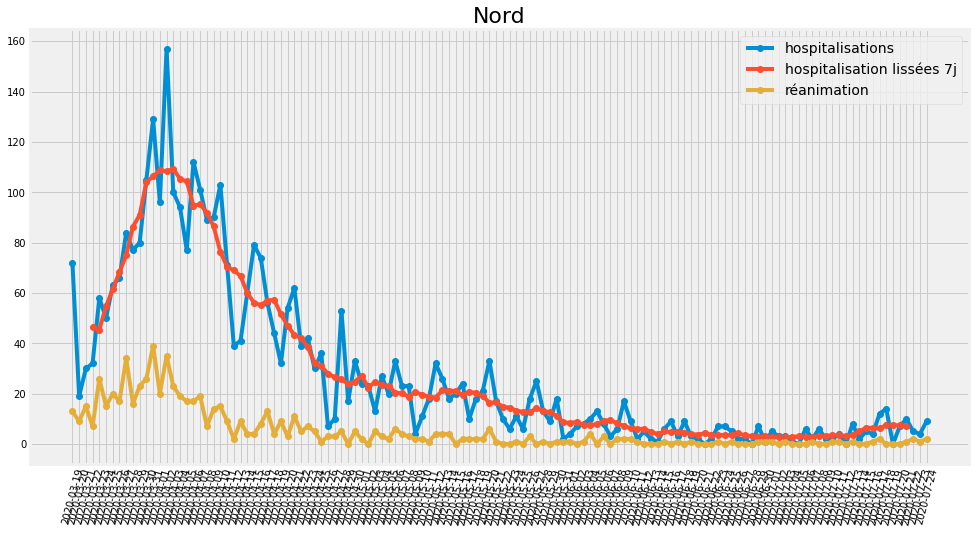


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17        12.0        2.0         6.0
2020-07-18        14.0        0.0         7.0
2020-07-19         0.0        0.0         7.0
2020-07-20         7.0        0.0         7.0
2020-07-21        10.0        1.0         7.0
2020-07-22         5.0        2.0         NaN
2020-07-23         4.0        1.0         NaN
2020-07-24         9.0        2.0         NaN


In [10]:
display_df(df[df.dep=="59"].set_index("jour", drop=True),"Nord")

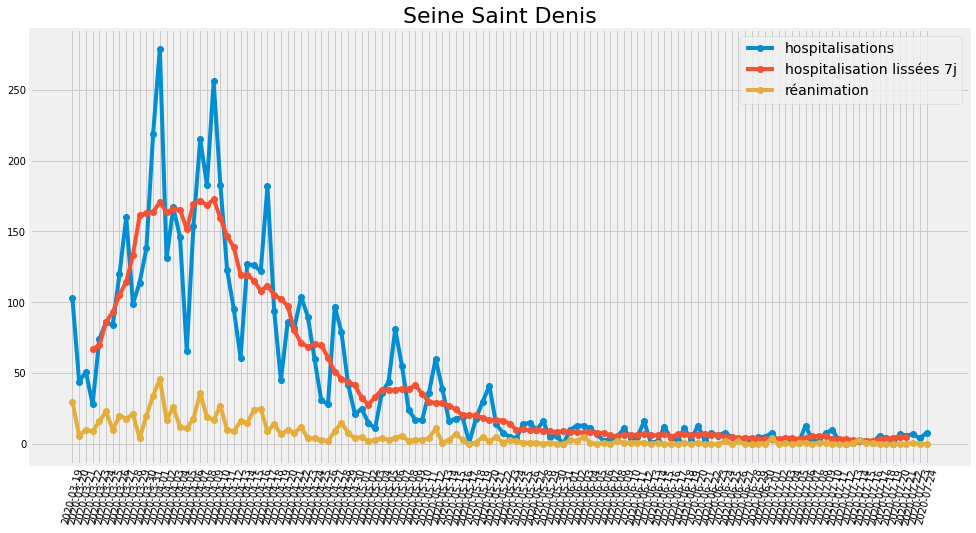


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         6.0        0.0         3.0
2020-07-18         4.0        0.0         4.0
2020-07-19         0.0        0.0         4.0
2020-07-20         7.0        0.0         5.0
2020-07-21         6.0        0.0         5.0
2020-07-22         7.0        1.0         NaN
2020-07-23         4.0        0.0         NaN
2020-07-24         8.0        0.0         NaN


In [11]:
display_df(df[df.dep=="93"].set_index("jour", drop=True),"Seine Saint Denis")

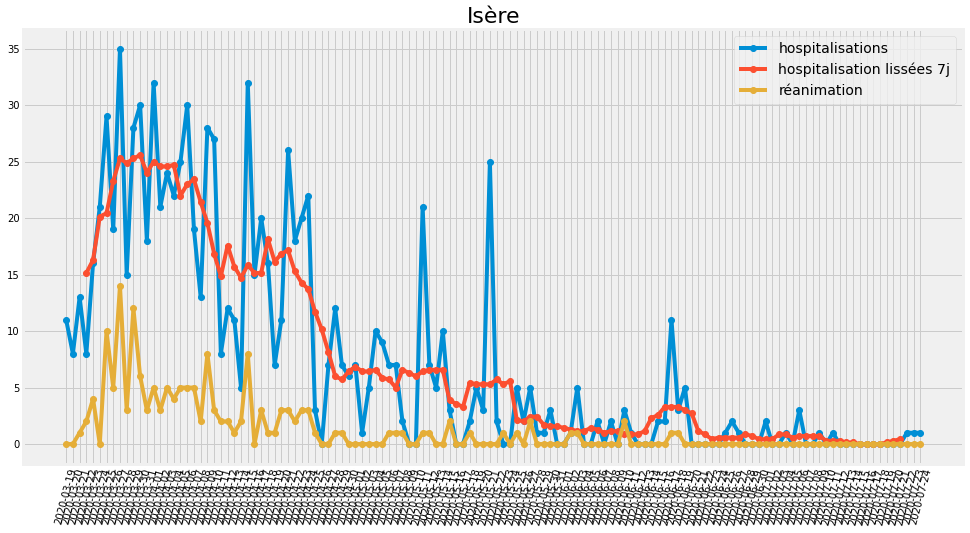


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         0.0        0.0         0.0
2020-07-18         0.0        0.0         0.0
2020-07-19         0.0        0.0         0.0
2020-07-20         0.0        0.0         0.0
2020-07-21         0.0        0.0         0.0
2020-07-22         1.0        0.0         NaN
2020-07-23         1.0        0.0         NaN
2020-07-24         1.0        0.0         NaN


In [12]:
display_df(df[df.dep=="38"].set_index("jour", drop=True),"Isère")

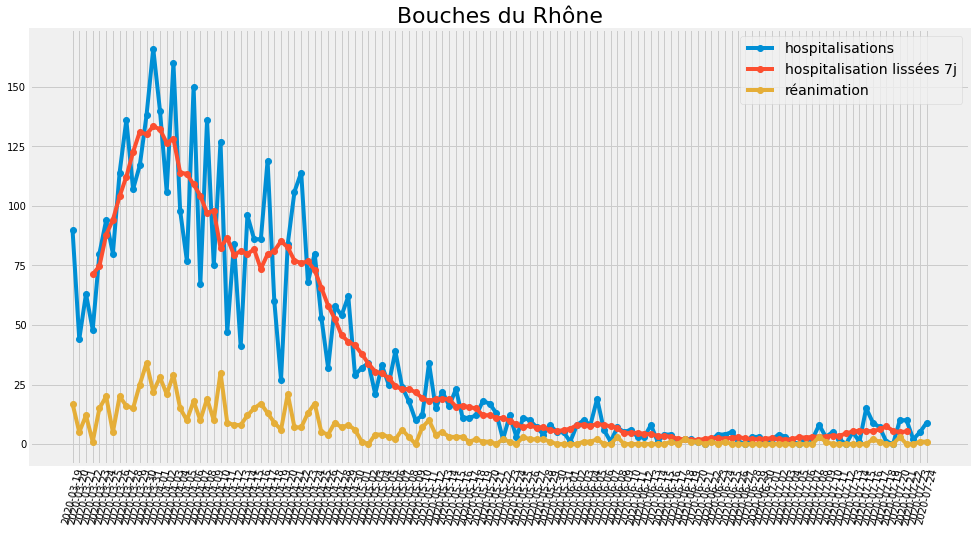


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         7.0        1.0         6.0
2020-07-18         1.0        0.0         7.0
2020-07-19         0.0        0.0         6.0
2020-07-20        10.0        3.0         5.0
2020-07-21        10.0        0.0         5.0
2020-07-22         2.0        0.0         NaN
2020-07-23         5.0        1.0         NaN
2020-07-24         9.0        1.0         NaN


In [13]:
display_df(df[df.dep=="13"].set_index("jour", drop=True),"Bouches du Rhône")

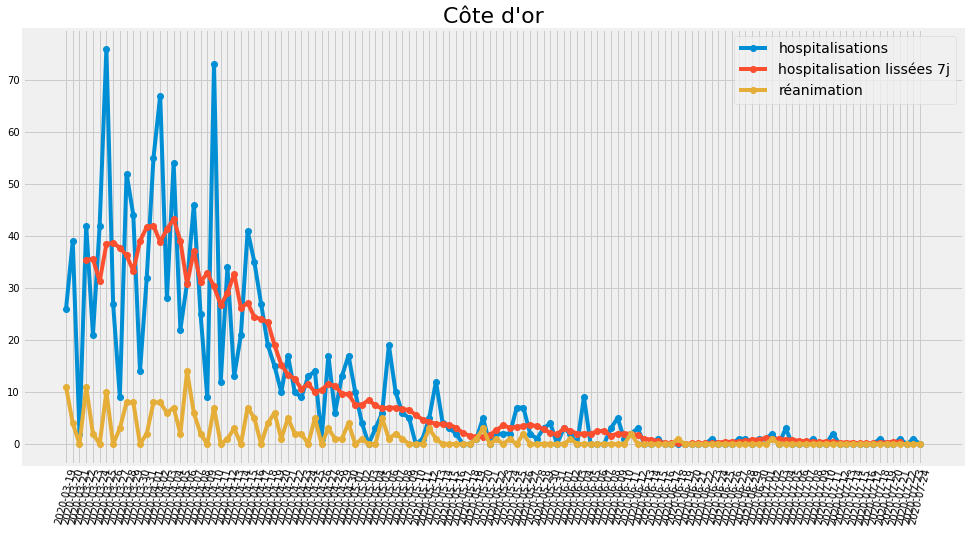


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         0.0        0.0         0.0
2020-07-18         1.0        0.0         0.0
2020-07-19         0.0        0.0         0.0
2020-07-20         0.0        0.0         0.0
2020-07-21         1.0        0.0         0.0
2020-07-22         0.0        0.0         NaN
2020-07-23         1.0        0.0         NaN
2020-07-24         0.0        0.0         NaN


In [14]:
display_df(df[df.dep=="21"].set_index("jour", drop=True),"Côte d'or")

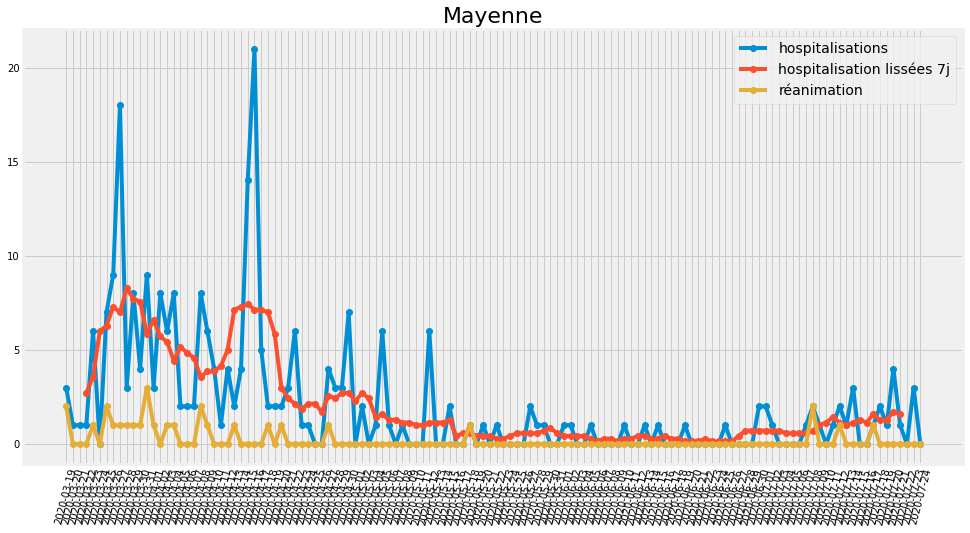


dernières données : 

            incid_hosp  incid_rea  hosp_lisse
jour                                         
2020-07-17         1.0        1.0         2.0
2020-07-18         2.0        0.0         1.0
2020-07-19         1.0        0.0         1.0
2020-07-20         4.0        0.0         2.0
2020-07-21         1.0        0.0         2.0
2020-07-22         0.0        0.0         NaN
2020-07-23         3.0        0.0         NaN
2020-07-24         0.0        0.0         NaN


In [15]:
display_df(df[df.dep=="53"].set_index("jour", drop=True),"Mayenne")

In [16]:
cumul = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-covid19",
    ";"
)

c = cumul.groupby(["dep", "jour"])["hosp", "rea"].sum().reset_index()
c.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,dep,jour,hosp,rea
13024,976,2020-07-23,20,6
13025,976,2020-07-24,26,4
13026,976,27/06/2020,68,8
13027,976,28/06/2020,68,8
13028,976,29/06/2020,66,10
